In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

def all_cells():    
    return HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this IPython notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# the functions below grabbed from http://www.astroml.org/book_figures/appendix/fig_neural_network.html
# our standard imports: matplotlib and numpy
import matplotlib.pyplot as plt
import numpy as np

# just to overwrite default colab style
plt.style.use('default')
plt.style.use('seaborn-talk')

radius = 0.3

arrow_kwargs = dict(head_width=0.05, fc='black')

def draw_connecting_arrow(ax, circ1, rad1, circ2, rad2):
    theta = np.arctan2(circ2[1] - circ1[1],
                       circ2[0] - circ1[0])

    starting_point = (circ1[0] + rad1 * np.cos(theta),
                      circ1[1] + rad1 * np.sin(theta))

    length = (circ2[0] - circ1[0] - (rad1 + 1.4 * rad2) * np.cos(theta),
              circ2[1] - circ1[1] - (rad1 + 1.4 * rad2) * np.sin(theta))

    ax.arrow(starting_point[0], starting_point[1],
             length[0], length[1], **arrow_kwargs)


def draw_circle(ax, center, radius):
    circ = plt.Circle(center, radius, fill=False, lw=2)
    ax.add_patch(circ)
    
# based on borrowed function we can create a new one to draw NN

def draw_net(input_size, output_size, hidden_layers=[], w=6, h=4):
  """Draw a network"""
  x = 0  # initial layer position
  
  ax = plt.subplot()
  ax.set_aspect('equal')
  ax.axis('off')

  ax.set_xlim([-2, -2 + w])
  ax.set_ylim([-h / 2 , h / 2 + 1])
  
  # set y position  
  y_input = np.arange(-(input_size - 1) / 2, (input_size + 1) / 2, 1)
  y_output = np.arange(-(output_size - 1) / 2, (output_size + 1) / 2, 1)
  y_hidden = [np.arange(-(n - 1) / 2, (n + 1) / 2, 1) for n in hidden_layers]
  
  # draw input layer
  plt.text(x, h / 2 + 0.5, "Capa\nEntrada", ha='center', va='top', fontsize=16)
  
  for i, y in enumerate(y_input):
    draw_circle(ax, (x, y), radius)
    ax.text(x - 0.9, y, '$x_%i$' % (input_size - 1 - i),
            ha='right', va='center', fontsize=16)
    draw_connecting_arrow(ax, (x - 0.9, y), 0.1, (x, y), radius)
  
  last_layer = y_input  # last layer y positions
  
  # draw hidden layers
  for ys in y_hidden:
    # shift x
    x += 2
    plt.text(x, h / 2 + 0.5, "Capa\nOculta", ha='center', va='top', fontsize=16)
    
    # draw neurons for each hidden layer
    for i, y1 in enumerate(ys):
      draw_circle(ax, (x, y1), radius)
      
      # connect a neuron with all neurons from previous layer
      if i != len(ys) - 1: # skip bias
        for y2 in last_layer:
          draw_connecting_arrow(ax, (x - 2, y2), radius, (x, y1), radius)
        
    # update last layer
    last_layer = ys
  
  x += 2  # update position for output layer
    
  # draw output layer
  plt.text(x, h / 2 + 0.5, "Capa\nSalida", ha='center', va='top', fontsize=16)

  for i, y1 in enumerate(y_output):
    draw_circle(ax, (x, y1), radius)
    ax.text(x + 0.8, y1, 'Salida', ha='left', va='center', fontsize=16)
    draw_connecting_arrow(ax, (x, y1), radius, (x + 0.8, y1), 0.1)

    # connect each output neuron with all neurons from previous layer
    for y2 in last_layer:
      draw_connecting_arrow(ax, (x - 2, y2), radius, (x, y1), radius)

all_cells()

<a id='inicio'></a>
# Proyecto 3: Redes Neuronales

## Integrantes: 

* Daniel Julián Rojas Cruz
* Johan Tanta Villanueva

En primer lugar, se muestra la clase **NeuronalNetwork**. Para poder mapear las neuronas de la red y su capa de entrada se le asigna un identificador a cada una ellas. De esta forma, a través de diccionarios de python obtendremos en tiempo constante el $bias$, $error$ y la salida($Z$) de cada neurona de la red. Asimismo, para identificar el peso de las aristas se le asigna una tupla como identificador.

In [2]:
hide_toggle(True)

In [3]:

import math, random

class NeuralNetwork():
    def __init__(self, n_entradas, n_salidas , capas = [] ):
        self.n_entradas = n_entradas
        self.n_salidas =  n_salidas
        self.n_capas = len(capas) + 2 #la capa de entrada + capas ocultas + la capa de salida

        self.bias = {}
        self.Z = {}
        self.error = {}
        self.capas = self.generate_capas(capas)
        self.W = self.generate_weights() 

    def generate_capas(self, capas):
        result = {}
        idx = 1
        #capa de entrada, esta sería la capa con indice 0
        #Estas como no son neuronas, solo es necesario asignar un ID
        result[0] = []
        for i in range(self.n_entradas):
            result[0].append(idx)
            idx += 1
        # capas ocultas, estan van desde en el intervalo de indices [1 - n_capas-2]
        # Aqui se encuentran las neuronal por lo que hay que mapearlas con un
        # identificador
        # Los identificadores de cada neurona se agregan en una lista, la cual representa
        # la capa que pertenecen
        for i in range(len(capas)):
            result[i+1] = []
            for j in range(capas[i]):
                # se genera el bias entre el intervalo [-0.1, 0.1]
                self.bias[idx] = random.uniform(-0.1,0.1)
                self.Z[idx] = 0
                self.error[idx] = 0
                result[i+1].append(idx)
                idx += 1
        #capa final, esta sería la capa con indice n_capas-1
        result[self.n_capas - 1] = []
        for i in range(self.n_salidas):
            # se genera el bias entre el intervalo [-0.1, 0.1]
            self.bias[idx] =random.uniform(-0.1,0.1)
            self.Z[idx] = 0
            self.error[idx] = 0
            result[self.n_capas - 1].append(idx)
            idx += 1
        return result

    #genera pesos aleatorios en el intervalo [-1, 1]
    def generate_weights(self):
        weights = {}

        for i in range(self.n_capas - 1):
            capa_i = self.capas[i]
            capa_ip1 = self.capas[i+1]
            #Los pesos de las aristas se le asigna un identificador como tupla
            for a in capa_i:
                for b in capa_ip1:
                    weights[(a,b)] = random.uniform(-1,1)
        return weights
    
    #Se obtiene el resultado de las neuronas que se encuentran en la capa de salida para ello
    #nos apoyamos de la funcion level_output la cual de manera recursiva obtiene los resultados de
    #las neuronas de la capa anterior.
    def fordward_propagation(self, X, Y):
        capa_final = self.capas[self.n_capas - 1]
        for i in range(len(capa_final)):
            p = self.level_output(self.n_capas - 1,capa_final[i],X)
 
            self.error[capa_final[i]] = Y[i] - p
        return 
    
    #Para obtener la salida de cada neurona (Z) se realiza de manera recursiva
    #El caso base es al encontrarnos en la capa 1, ya que la capa 0 es la capa de entrada
    #Por lo que se utiliza las funciones propias de una neurona.
    #En caso contrario tendriamos el valor Z_i de las neuronas de la capa anterior 
    #por lo que directamente se calcula la salida Z_j de la neurona actual con las aristas relacionadas a ella
    def level_output(self,capa, neurona_id, X):    
        sumatoria = 0
        if (capa == 1):
            for i in range(len(X)):
                sumatoria += X[i]*self.W[(i+1,neurona_id)]  

            y_prob = self.__sigmoide(sumatoria)
            self.Z[neurona_id] = y_prob
            return y_prob
        #Las aristas relacionada a la neurona están dadas con el identificador de la neurona actual y 
        #el ID de las neuronas de la capa anterior
        for neurona in self.capas[capa - 1]:
            sumatoria += self.level_output(capa - 1, neurona, X)*self.W[(neurona,neurona_id)]

        y_prob = self.__sigmoide(sumatoria) + self.bias[neurona_id]
        self.Z[neurona_id] = y_prob
        return y_prob
    #Se asigna el error de cada neurona de manera recursiva con apoyo de la función de abajo
    def retro_propagation(self):
        capa_inicial = self.capas[1]

        for neurona in capa_inicial:
            self.level_error(1,neurona)
  
    #Se asigna el error de cada neurona y se actualiza el bias
    #Esta funcion es recursiva, se llama a esta funcion para la capa siguiente.
    def level_error(self,capa, neurona_id):
        if (capa == self.n_capas - 1):
            #Este error fue asignado en forward_propagation
            return self.error[neurona_id]

        error = 0
        for neurona in self.capas[capa + 1]:
            error += self.level_error(capa + 1,neurona)*self.W[(neurona_id,neurona)]
        self.error[neurona_id] = error
        self.bias[neurona_id] += error*self.__gradiente(self.Z[neurona_id])
        return error
    #Esta funcion realizada la llamada de la funcion de abajo la cual es recursiva y es la encargada
    #de actualizar todos los pesos.
    #En esta funcion se realiza la llamada inicial con los identificadores de las neuronas de la capa final
    def update_weigths(self,X):
        capa_final = self.capas[self.n_capas - 1]

        for neurona in capa_final:
            self.level_update_weight(self.n_capas - 1, neurona,X)  
        return
    
    #Esta funcion es recursiva, la cual actualiza los pesos relacionados a una neurona en la capa i 
    #con las neuronas en la capa i-1
    #El caso base es cuando nos encontramos en la capa 1, ya que la capa 0 es la capa de entrada
    def level_update_weight(self, capa , neurona_id, X):
        if (capa == 1):
            for i in range(len(X)):
                self.W[(i+1, neurona_id)] +=   X[i]*self.error[neurona_id]*self.__gradiente(self.Z[neurona_id])  
            return

        for neurona in self.capas[capa - 1]:
            self.level_update_weight(capa - 1,neurona, X)  

        for neurona in self.capas[capa - 1]:
            self.W[(neurona, neurona_id)] += self.level_output(capa -1, neurona, X)*self.error[neurona_id]*self.__gradiente(self.Z[neurona_id])  

    def back_propagation(self,X, Y):
        self.fordward_propagation(X,Y)
        self.retro_propagation() #Se asigna el error de cada neurona y se actualiza el bias
        self.update_weigths(X) #Actualizar los pesos de acuerdo a lo anterior
    
    #Se obtiene el valor, la cual representa la prediccion de nuestra red neuronal
    def predict(self,X):
        y_proba = []
        capa_final = self.capas[self.n_capas - 1]
        #Si hay varias neuronas en la capa final, se obtienen todos los resultados
        for n in capa_final:
            p = self.level_output(self.n_capas - 1,n,X) + self.bias[n]
            y_proba.append(p)

        return y_proba  

    # Se entrena la red neuronal utilizando el algoritmo back propagation
    def fit(self, d_ent, epocas):
        for _ in range(epocas):
            for reg in d_ent:
                X = reg['X']
                Y = reg['Y']
                self.back_propagation(X,Y)

        return
    
    # Funciones propias de una neurona.
    def __sumatoria(self, X):
        suma = 0
        for i, x in enumerate(X):
            suma += self.W[i]*x
        return suma

    def __sigmoide( self, suma ):
        return 1/(1+math.exp(-suma))

    def __gradiente(  self, y_proba ):
        return y_proba*(1-y_proba)

## Explicación de la propuesta
### Ejemplo 1:
De acuerdo al siguiente dataset: 

ID | $X_1$ | $X_2$ | $X_3$ | $Y$
--- | --- |  --- |  --- |  --- |
1 | 0 | 0 | 1 | 1
2 | 1 | 0 | 0 | 0
3 | 0 | 1 | 0 | 0
4 | 1 | 1 | 1 | 1
5 | 0 | 1 | 1 | 1

Se inicializa la red neuronal con la siguiente arquitectura:

In [4]:
hide_toggle(True)

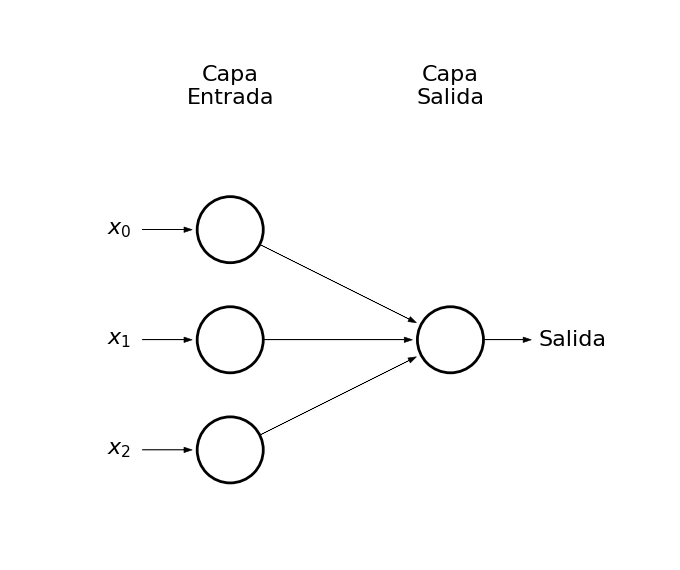

In [5]:
draw_net(3,1)

En la cual se observa que la capa de entrada tiene 3 elementos ($X_1$, $X_2$, $X_3$) y una capa de salida.
Por lo que en el constructor de la clase **NeuronaNetwork** se inicializa de la siguiente forma

```
class NeuralNetwork():
    def __init__(self, n_entradas, n_salidas , capas = [] ):
        self.n_entradas = n_entradas
        self.n_salidas =  n_salidas
        self.n_capas = len(capas) + 2 #la capa de entrada + capas ocultas + la capa de salida

        self.bias = {}
        self.Z = {}
        self.error = {}
        self.capas = self.generate_capas(capas)
        self.W = self.generate_weights() 

red = NeuralNetwork(3, 1, [])
```
Al no haber capas ocultas, el tercer argumento es una lista vacía. Por lo que el atributo $n_capas$ está dada conformada por la cantidad de capas ocultas, la capa de entrada y la capa de salida. El siguiente paso es inicializar los diccionarios para poder mapear el valor de $bias$, $error$, salida ($Z$) de cada neurona y, también, los pesos de las aristas.

Cada capa está representada como una lista, en cada lista se guarda el identificador(**ID**) de cada neurona o entrada. En el caso de la capa de entrada la cual es el indice cero, solo guarda en esta lista los identificadores necesarios.
```
    def generate_capas(self, capas):
        result = {}
        idx = 1
        #capa de entrada, esta sería la capa con indice 0
        #Estas como no son neuronas, solo es necesario asignar un ID
        result[0] = []
        for i in range(self.n_entradas):
            result[0].append(idx)
            idx += 1
```
A partir de la capa 1, se encuentran las neuronas por lo que en esa lista se guarda el identificador de esa neurona y se inicializa en los diccionarios con el mismo identificador.
```
        # capas ocultas, estan van desde en el intervalo de indices [1 - n_capas-2]
        # Aqui se encuentran las neuronal por lo que hay que mapearlas con un
        # identificador
        # Los identificadores de cada neurona se agregan en una lista, la cual representa
        # la capa que pertenecen
        for i in range(len(capas)):
            result[i+1] = []
            for j in range(capas[i]):
                # se genera el bias entre el intervalo [-0.1, 0.1]
                self.bias[idx] = random.uniform(-0.1,0.1)
                self.Z[idx] = 0
                self.error[idx] = 0
                result[i+1].append(idx)
                idx += 1
```
Luego de realizar la asignacion de los identificadores de las neuronas de cada capa oculta, se inicializa las neuronas de la capa oculta. 
```
        #capa final, esta sería la capa con indice n_capas-1
        result[self.n_capas - 1] = []
        for i in range(self.n_salidas):
            # se genera el bias entre el intervalo [-0.1, 0.1]
            self.bias[idx] =random.uniform(-0.1,0.1)
            self.Z[idx] = 0
            self.error[idx] = 0
            result[self.n_capas - 1].append(idx)
            idx += 1
        return result
```
De igual forma con la asignacion de los pesos de las aristas. En este caso el identificador es una tupla la cual indica de donde parte y hacia donde se dirige
```
def generate_weights(self):
        weights = {}

        for i in range(self.n_capas - 1):
            capa_i = self.capas[i]
            capa_ip1 = self.capas[i+1]
            #Los pesos de las aristas se le asigna un identificador como tupla
            for a in capa_i:
                for b in capa_ip1:
                    weights[(a,b)] = random.uniform(-1,1)
        return weights
```
Luego de la construccion de la red neuronal se procede a entrenar la red donde se pasa el dataframe y el número de épocas
```
red.fit(d_ent, 5)
```
En el entrenamiento se utiliza el algoritmo de back propagation
```
    def fit(self, d_ent, epocas):
        for _ in range(epocas):
            for reg in d_ent:
                X = reg['X']
                Y = reg['Y']
                self.back_propagation(X,Y)

    def back_propagation(self,X, Y):
        self.fordward_propagation(X,Y)
        self.retro_propagation() #Se asigna el error de cada neurona y se actualiza el bias
        self.update_weigths(X) #Actualizar los pesos de acuerdo a lo anterior
```
En primer lugar, se realiza la llamada de la funcion **fordward_propagation** la cual se apoya de la funcion **level_output**, esta última obtiene los resultados de las neuronas que se encuentran en la capa final. Pero para ello obtener, de manera recursiva se obtiene los resultados de las neuronas de la capa anterior. Luego de obtener los resultados, se asigna directamente el error que han tenido las neuronas de la capa de salida.
```
#Se obtiene el resultado de las neuronas que se encuentran en la capa de salida para ello
    #nos apoyamos de la funcion level_output la cual de manera recursiva obtiene los resultados de
    #las neuronas de la capa anterior.
    def fordward_propagation(self, X, Y):
        capa_final = self.capas[self.n_capas - 1]
        for i in range(len(capa_final)):
            p = self.level_output(self.n_capas - 1,capa_final[i],X)
 
            self.error[capa_final[i]] = Y[i] - p
        return 
```
Al ser una funcion recursiva, el caso base es cuando nos encontramos en la capa 1 ya que la capa de índice cero representa la capa de entrada. Por lo tanto, se utiliza las funciones propias de una neurona. Asimismo se obtiene el peso de las aristas relacionadas a la neurona actual con el identificador que sería una tupla.
```
    #Para obtener la salida de cada neurona (Z) se realiza de manera recursiva
    #El caso base es al encontrarnos en la capa 1, ya que la capa 0 es la capa de entrada
    #Por lo que se utiliza las funciones propias de una neurona.
    #En caso contrario tendriamos el valor Z_i de las neuronas de la capa anterior 
    #por lo que directamente se calcula la salida Z_j de la neurona actual con las aristas relacionadas a ella
    def level_output(self,capa, neurona_id, X):    
        sumatoria = 0
        if (capa == 1):
            for i in range(len(X)):
                sumatoria += X[i]*self.W[(i+1,neurona_id)]  

            y_prob = self.__sigmoide(sumatoria)
            self.Z[neurona_id] = y_prob
            return y_prob
        #Las aristas relacionada a la neurona están dadas con el identificador de la neurona actual y 
        #el ID de las neuronas de la capa anterior
        for neurona in self.capas[capa - 1]:
            sumatoria += self.level_output(capa - 1, neurona, X)*self.W[(neurona,neurona_id)]

        y_prob = self.__sigmoide(sumatoria) + self.bias[neurona_id]
        self.Z[neurona_id] = y_prob
        return y_prob
```
Luego que termine la funcion de **forward_propagtion**, se procede con la función **retro_propagation**. Esta función se encarga de asignar el error que ha tenido cada neurona por lo que se apoya de una funcion recursiva **level_error**.
```
#Se asigna el error de cada neurona de manera recursiva con apoyo de la función de abajo
    def retro_propagation(self):
        capa_inicial = self.capas[1]

        for neurona in capa_inicial:
            self.level_error(1,neurona)
```
La función **level_error**, realiza llamadas de ellas misma de las capas siguientes por lo que el punto de parada es cuando nos encontramos en la capa de salida. En esta capa todas las neuronas tiene asignadas el error que hayan obtenido. Asimismo, se modifica el $bias$ de cada neurona.
```
    #Se asigna el error de cada neurona y se actualiza el bias
    #Esta funcion es recursiva, se llama a esta funcion para la capa siguiente.
    def level_error(self,capa, neurona_id):
        if (capa == self.n_capas - 1):
            #Este error fue asignado en forward_propagation
            return self.error[neurona_id]

        error = 0
        for neurona in self.capas[capa + 1]:
            error += self.level_error(capa + 1,neurona)*self.W[(neurona_id,neurona)]
        self.error[neurona_id] = error
        self.bias[neurona_id] += error*self.__gradiente(self.Z[neurona_id])
        return error
```
Se realiza la última llamada a la funcion **update_weights** la cual se encarga de actualizar el peso de todas las aristas. Esta se apoya de la funcion **level_update_weight**, la cual es una función recursiva donde su punto de parada es la capa 1.
```
    #Esta funcion realizada la llamada de la funcion de abajo la cual es recursiva y es la encargada
    #de actualizar todos los pesos.
    #En esta funcion se realiza la llamada inicial con los identificadores de las neuronas de la capa final
    def update_weigths(self,X):
        capa_final = self.capas[self.n_capas - 1]

        for neurona in capa_final:
            self.level_update_weight(self.n_capas - 1, neurona,X)  
        return
    
    #Esta funcion es recursiva, la cual actualiza los pesos relacionados a una neurona en la capa i 
    #con las neuronas en la capa i-1
    #El caso base es cuando nos encontramos en la capa 1, ya que la capa 0 es la capa de entrada
    def level_update_weight(self, capa , neurona_id, X):
        if (capa == 1):
            for i in range(len(X)):
                self.W[(i+1, neurona_id)] +=   X[i]*self.error[neurona_id]*self.__gradiente(
                                                                                  self.Z[neurona_id])  
            return

        for neurona in self.capas[capa - 1]:
            self.level_update_weight(capa - 1,neurona, X)  

        for neurona in self.capas[capa - 1]:
            self.W[(neurona, neurona_id)] += self.level_output(capa -1, neurona, 
                                            X)*self.error[neurona_id]*self.__gradiente(self.Z[neurona_id])  
```
Finalmente, se realiza la prediccion de nuestra red neuronal con la funcion **predict**
```
red.predict([1,1,0])
```
Se le pasa los valores del vector X ($X_1$, $X_2$, $X_3$). Esta funcion retorna los resultados de la capa final, en este caso solo es una neurona por lo que solo hay un valor en la lista. Asimismo, obtener los resultados basta con llamar la funcion **level_output** y agregarle el $bias$ de la neurona.
```
#Se obtiene el valor, la cual representa la prediccion de nuestra red neuronal
    def predict(self,X):
        y_proba = []
        capa_final = self.capas[self.n_capas - 1]
        #Si hay varias neuronas en la capa final, se obtienen todos los resultados
        for n in capa_final:
            p = self.level_output(self.n_capas - 1,n,X) + self.bias[n]
            y_proba.append(p)

        return y_proba  
```    

In [6]:
hide_toggle(True)

In [7]:
d_ent = [
         {"X":[0,0,1], "Y":[1]},#ID1
         {"X":[1,0,0], "Y":[0]},#ID2
         {"X":[0,1,0], "Y":[0]},#ID3
         {"X":[1,1,1], "Y":[1]},#ID4
         {"X":[0,1,1], "Y":[1]},#ID5
]

red_1 = NeuralNetwork(3,1,[])
red_1.fit(d_ent,5)
p = red_1.predict([1,1,0])
print("Valor real de la neurona: {:.2f}".format(p[0]))
print("Prediccion : {:.0f}".format(p[0]))

Valor real de la neurona: 0.64
Prediccion : 1


## Ejemplo 2

De acuerdo al siguiente dataset: 

ID | $X_1$ | $X_2$ | $Y$|
--- | --- |  --- |  --- |
1 | 0 | 1 | 1 |
2 | 1 | 0 | 1 |
3 | 0 | 0 | 0 |
4 | 1 | 1 | 0 |
5 | 0 | 1 | 1 |

Podemos notar que este dataset es el caso del operador XOR, el cual da verdadero(1) solo si exactamente uno de los 2 elementos es verdadero(1). Vamos a entrenar  una red.


La primera propuesta será inicializar la red neuronal con la siguiente arquitectura:

In [8]:
hide_toggle(True)

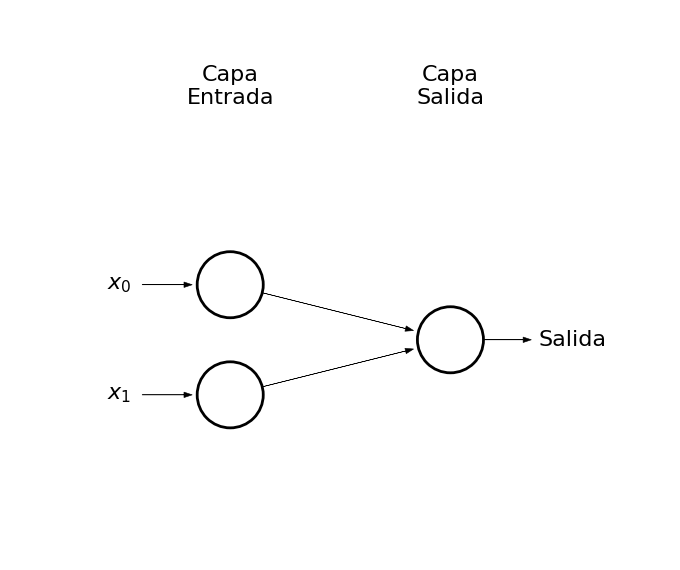

In [9]:
draw_net(2,1)

Esta arquitectura tiene 2 entradas y 1 salida. Un problema con esta arquitectura es que no se podrá separar los puntos en 2 grupos mediante una sola recta.

In [10]:
hide_toggle(True)

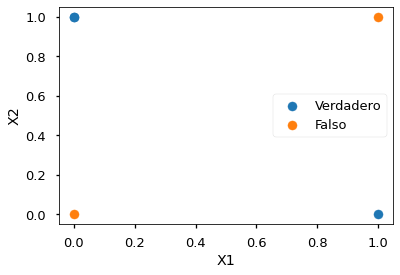

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter( [0,1,0], [1,0,1], label='Verdadero' )
plt.scatter( [0,1], [0,1], label='Falso' )
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()

In [12]:
hide_toggle(True)

In [13]:
d_ent2 = [
         {"X":[0,1], "Y":[1]},#ID1
         {"X":[1,0], "Y":[1]},#ID2
         {"X":[0,0], "Y":[0]},#ID3
         {"X":[1,1], "Y":[0]},#ID4
         {"X":[0,1], "Y":[1]},#ID5
]
red_2 = NeuralNetwork(2,1,[])
red_2.fit(d_ent2,5)
p = red_2.predict([1,1])
p2 = red_2.predict([1,0])
print("Valor real de la neurona: {:.2f}".format(p[0]))
print("Prediccion 1: {:.0f}".format(p[0]))

print("Valor real de la neurona: {:.2f}".format(p2[0]))
print("Prediccion 2: {:.0f}".format(p2[0]))

Valor real de la neurona: 0.63
Prediccion 1: 1
Valor real de la neurona: 0.43
Prediccion 2: 0


## Ejemplo 3

Trabajaremos con el mismo dataset pero esta vez con una capa oculta de 2 neuronas. En teoría con esta arquitectura podriamos dividir el espacio con 2 rectas en grupos de igual valor


In [14]:
hide_toggle(True)

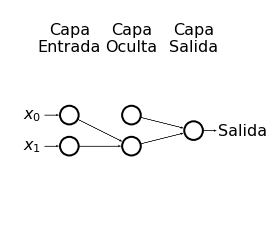

In [15]:
draw_net(2,1,[2],w=8 ,h=6)

In [16]:
hide_toggle(True)

In [17]:
d_ent2 = [
         {"X":[0,1], "Y":[1]},#ID1
         {"X":[1,0], "Y":[1]},#ID2
         {"X":[0,0], "Y":[0]},#ID3
         {"X":[1,1], "Y":[0]},#ID4
         {"X":[0,1], "Y":[1]},#ID5
]
red_3 = NeuralNetwork(2,1,[2])
red_3.fit(d_ent2,2)
p = red_3.predict([1,1])

print("Valor real de la neurona: {:.2f}".format(p[0]))
print("Prediccion 1: {:.0f}".format(p[0]))





Valor real de la neurona: 0.51
Prediccion 1: 1


Predecimos el valor (1,1) con nuestra red y obtenemos el valor esperado

### Experimentos
Para realizar los experimentos, se extrajo los datos de la siguiente página: https://www.kaggle.com/c/titanic . Es decir, el escenario del experimento es para determinar si una persona con determinadas caracteristicas sobrevive o no si viaja, en ese entonces, en el Titanic. Las caracteristicas que se eligieron fueron las siguientes:
- **pclass (Ticket class)**: Para saber en status de la persona de acuerdo a su ticket
- **sex**: El sexo de la persona. Incluso, hoy en día, la frase de "Primero los niños y mujers" se sigue utilizando
- **RangeAge**: El rango de edad está dado para niños, jóvenes, adultos y ancianos. Previamente, se tuvo que parsear el dataframe para eliminar las filas donde el valor de la columna **Age** es nulo. Luego se asigno en una nueva columna el rango de edad.
- **sibsp**: # de hermanas / cónyuges a bordo del Titanic
- **parch**: # de padres / hijos a bordo del Titanic

Luego de identificar las variables y haber realizado un parser al dataframe titanic.csv, se realiza a leer dataframe de entrenamiento y de prueba. Asimismo, estos dataframes se transforman a datos numeros para que la red neuronal pueda leer.

In [18]:
hide_toggle(True)

In [19]:
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_parser = train.apply( LabelEncoder().fit_transform )
test_parser = test.apply( LabelEncoder().fit_transform )
df_train = []
for i in range(len(train_parser.index)):
    elem = {}
    elem['Y'] = train_parser.iloc[i].tolist()
    elem['X'] = train_parser.iloc[i].tolist()[1:]
    df_train.append(elem)

Se definen las siguientes arquitecturas:

In [20]:
hide_toggle(True)

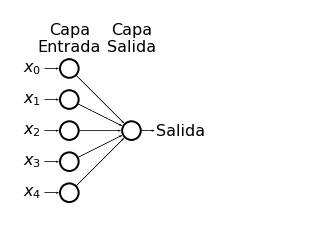

In [21]:
draw_net(5,1, w=10, h=6)
red_titanic1 = NeuralNetwork(5,1,[])

In [22]:
hide_toggle(True)

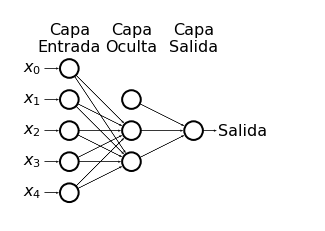

In [23]:
draw_net(5,1,[3], w=10, h=6)
red_titanic2 = NeuralNetwork(5,1,[3])

In [24]:
hide_toggle(True)

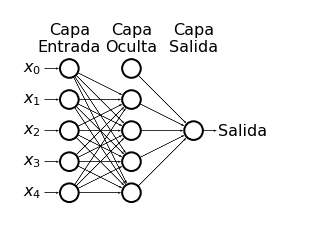

In [25]:
draw_net(5,1,[5], w=10, h=6)
red_titanic3 = NeuralNetwork(5,1,[5])

Se empieza el entrenamiento de cada red neuronal

In [26]:
hide_toggle(True)

In [27]:
red_titanic1.fit(df_train, 2)
red_titanic2.fit(df_train, 2)
red_titanic3.fit(df_train, 4)

Luego de entrenar las redes neuronales, con ayuda de un dataframe de prueba generamos las matrices de confusion.

In [28]:
hide_toggle(1)

In [29]:
def construir_matriz_confusion( y_real, y_modelo, n_clases ):
    matriz = [ [0]*n_clases for _ in range(n_clases) ]
    M = len(y_real)
    for m in range(M):
        clase_real = y_real[m]
        clase_predecida = y_modelo[m]
        matriz[ clase_predecida ][ clase_real ] += 1
    return matriz


y_real = test_parser["Survived"].tolist()
y1 = []
y2 = []
y3 = []
for i in range(len(y_real)):
    X = test_parser.iloc[i].tolist()[1:]
    valor1 = red_titanic1.predict(X)
    valor2 = red_titanic2.predict(X)
    valor3 = red_titanic3.predict(X)
    y1.append(round(valor1[0]))
    y2.append(round(valor2[0]))
    y3.append(round(valor3[0]))

In [30]:
hide_toggle(1)

In [31]:
m_confusion1 = construir_matriz_confusion(y_real, y1, 2)
m_confusion2 = construir_matriz_confusion(y_real, y2, 2)
m_confusion3 = construir_matriz_confusion(y_real, y3, 2)
print("Matriz de confusion de la Red N° 1")
for fila in m_confusion1:
    print(fila)
print("Matriz de confusion de la Red N° 2")
for fila in m_confusion2:
    print(fila)
print("Matriz de confusion de la Red N° 3")
for fila in m_confusion3:
    print(fila)

Matriz de confusion de la Red N° 1
[96, 37]
[12, 34]
Matriz de confusion de la Red N° 2
[100, 41]
[8, 30]
Matriz de confusion de la Red N° 3
[104, 39]
[4, 32]


La cual con las metricas, observaremos cual red neuronal ha predicho mejor que las otras. Asimismo el tamaño de la matriz de confusion es 2x2 y nuestra clase de interes es haber determinado si la persona sobrevive, la cual está dado por el valor **1**. Entonces, el valor de **verdadero positivo** se encuentra en la posicion (1,1) de la matriz 

In [32]:
hide_toggle(1)

In [33]:
def accuracy_n(matriz_confusion):
  # nro de clases 
  n_clases = len(matriz_confusion)
  true_cases  = 0
  for i in range(n_clases):
    true_cases += matriz_confusion[i][i]
  total_cases = 0
  for fila in matriz_confusion:
    total_cases += sum(fila)
  return true_cases/total_cases

def precision_n(matriz_confusion):
  n_clases = len(matriz_confusion)
  precision_list = []
  for i in range(n_clases):
    tp = matriz_confusion[i][i]
    suma = sum(matriz_confusion[i])
    if(suma == 0):
      precision_i = 0
    else:
      precision_i = tp/suma
    precision_list.append(precision_i)
  return precision_list

def recall_n(matriz_confusion):
  n_clases = len(matriz_confusion)
  recall_list = []
  for i in range(n_clases):
    tp = matriz_confusion[i][i]
    total = 0
    for j in range(n_clases):
      total += matriz_confusion[j][i]
    if(total == 0):
      recall_i = 0
    else:
      recall_i = tp/total
    recall_list.append(recall_i)
  return recall_list
  

def f1_n(matriz_confusion):
  prec_n = precision_n(matriz_confusion)
  rec_n = recall_n(matriz_confusion)
  list_f1 = []
  assert len(prec_n) == len(rec_n), "invalido"
  n_clases = len(prec_n)
  for i in range(n_clases):
    if(prec_n[i] + rec_n[i] == 0):
      f1_i = 0
    else:
      f1_i = 2 *prec_n[i]*rec_n[i]/(prec_n[i]+rec_n[i])
    list_f1.append(f1_i)
  return list_f1

def macro_precision(matriz_confusion):
  n_clases  = len(matriz_confusion)
  prec_n = precision_n(matriz_confusion)
  
  suma = 0
  for i in range(n_clases):
    suma += prec_n[i]
  return suma/n_clases

def macro_recall(matriz_confusion):
  n_clases  = len(matriz_confusion)
  rec_n = recall_n(matriz_confusion)
  
  suma = 0
  for i in range(n_clases):
    suma += rec_n[i]
  return suma/n_clases

def macro_f1(matriz_confusion):
  n_clases = len(matriz_confusion)
  f_n = f1_n(matriz_confusion)
  suma = 0
  for i in range(n_clases):
    suma += f_n[i]
  return suma/n_clases

In [34]:
hide_toggle(1)

In [35]:
print("Metrica accuracy para Red 1: ", accuracy_n(m_confusion1)*100)
print("Metrica Recall para Red 1: ", recall_n(m_confusion1)[1]*100)
print("Metrica Precision para Red 1: ", precision_n(m_confusion1)[1]*100)
print("Metrica f1 para Red 1: ", f1_n(m_confusion1)[1]*100)

Metrica accuracy para Red 1:  72.62569832402235
Metrica Recall para Red 1:  47.88732394366197
Metrica Precision para Red 1:  73.91304347826086
Metrica f1 para Red 1:  58.11965811965811


In [36]:
hide_toggle(1)

In [37]:
print("Metrica accuracy para Red 2: ", accuracy_n(m_confusion2)*100)
print("Metrica Recall para Red 2: ", recall_n(m_confusion2)[1]*100)
print("Metrica Precision para Red 2: ", precision_n(m_confusion2)[1]*100)
print("Metrica f1 para Red 2: ", f1_n(m_confusion2)[1]*100)

Metrica accuracy para Red 2:  72.62569832402235
Metrica Recall para Red 2:  42.25352112676056
Metrica Precision para Red 2:  78.94736842105263
Metrica f1 para Red 2:  55.04587155963302


In [38]:
hide_toggle(1)

In [39]:
print("Metrica accuracy para Red 3: ", accuracy_n(m_confusion3)*100)
print("Metrica Recall para Red 3: ", recall_n(m_confusion3)[1]*100)
print("Metrica Precision para Red 3: ", precision_n(m_confusion3)[1]*100)
print("Metrica f1 para Red 3: ", f1_n(m_confusion3)[1]*100)

Metrica accuracy para Red 3:  75.97765363128491
Metrica Recall para Red 3:  45.07042253521127
Metrica Precision para Red 3:  88.88888888888889
Metrica f1 para Red 3:  59.813084112149525


## Conclusiones
- Al haber pocas neuronas, como en la primera arquitectura se observa que las métricas de calidad son bajas por lo que al tener pocas neuronas, la prediccion de la red es bajo.
- Se observa que a mayor cantidad de neuronas como en la arquitectura 2 y 3, hay una mayor eficiencia en la prediccion, es decir, es posible predecir con una tasa relativamente alta si una persona sobrevive o no si encuentra en el titanic. 

## Limitante
- No se pudo colocar mas capas ocultas porque ocasionaba overflow, es decir, se activaba la excepcion de "math range error"